In [1]:
# Importing necessary libraries

import time
import os
import math
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image, ImageFilter
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms

from util.util import save_images, mkdir

In [2]:
# Dictionary to hold parameters

parameters = {
    'dataroot': './samples', # Path to the dataset directory
    'name': 'pam', # Name of the experiment or model
    'gpu_ids': '-1', # GPU IDs to use, '-1' means using CPU
    'checkpoints_dir': './checkpoints', # Directory to save model checkpoints
    'model': 'CDFA', # Model name or type
    'input_nc': 3, # Number of input channels (e.g., 3 for RGB images)
    'output_nc': 3, # Number of output channels
    'arch': 'mynet3', # Architecture type or name
    'f_c': 64, # Number of filters in the convolution layers
    'n_class': 2, # Number of output classes
    'init_type': 'normal', # Initialization method for model weights
    'init_gain': 0.02, # Gain for the initialization method
    'SA_mode': 'PAM', # Mode for Self-Attention, 'PAM' in this case
    'ds': 1, # Downsampling factor
    'angle': 0, # Angle parameter, for data augmentation
    'istest': False, # Flag to indicate if the mode is testing
    'serial_batches': False, # If True, loads data in a fixed order
    'num_threads': 4, # Number of threads for data loading
    'batch_size': 1,  # Number of samples per batch
    'load_size': 286, # Size to resize images before cropping
    'crop_size': 256, # Size of the crop applied to images
    'max_dataset_size': float("inf"), # Maximum size of the dataset to load
    'preprocess': 'none1',  # Preprocessing method to apply to images
    'no_flip': True,  # Disable horizontal flipping during preprocessing
    'no_flip2': True, # Possibly another flag related to flipping
    'display_winsize': 256, # Display window size
    'epoch': 'pam', # Specific epoch to load or use
    'load_iter': 0, # Iteration to load the model from
    'verbose': False, # Verbosity flag for logging
    'suffix': '', # Suffix for saving the model or results
    'num_threads': 0,  # Number of threads for data loading
    'batch_size': 1,  # Batch size for testing
    'serial_batches': True,  # Load images in order
    'no_flip': True,  # Disable flipping
    'no_flip2': True, # Disable flipping
    'display_id': -1,  # ID for displaying results; -1 means no display
    'phase': 'test', # Phase of the experiment, 'test' in this case
    'preprocess': 'none1',  # Preprocessing method
    'isTrain': False,  # Indicates that this is not training mode
    'aspect_ratio': 1,  # Aspect ratio for resizing images
    'eval': True, # Evaluation mode flag
    'results_dir': './samples/output/', # Directory to save the results
    'data_dir': './samples', # Directory of the dataset
    'num_test': np.inf # Number of test samples to use
}

# Convert the dictionary into a named tuple for easier access
Opt = namedtuple('Opt', parameters.keys())
opt = Opt(**parameters)


### This cell defines the get_params function, which generates random parameters for image transformations based on the provided options (opt) and image size.

In [3]:
def get_params(opt, size, test=False):
  """
  This function generates random parameters for image transformations based on the parameters and image size.

  Args:
    opt: A dictionary containing options for image preprocessing.
    size: A tuple representing the original image size (width, height).
    test: A boolean flag indicating whether it's training or testing phase (default: False).

  Returns:
    A dictionary containing transformation parameters:
      - crop_pos: (x, y) coordinates for random cropping (if applicable).
      - flip: A boolean indicating horizontal flip (True) or not (False).
      - angle: A random rotation angle in degrees (if applicable).
  """

  w, h = size  # Unpack width and height from the size tuple
  new_h = h  # Initialize new height (potentially modified)
  new_w = w  # Initialize new width (potentially modified)
  angle = 0  # Initialize rotation angle (default: 0 degrees)

  # Apply resize and crop transformation based on options
  if opt.preprocess == 'resize_and_crop':
    new_h = new_w = opt.load_size  # Resize both height and width to the specified size

  # Apply random rotation during training
  if 'rotate' in opt.preprocess and test is False:
    angle = random.uniform(0, opt.angle)  # Generate random angle within the specified range
    # Calculate new width and height considering rotation
    new_w = int(new_w * math.cos(angle * math.pi / 180) + new_h * math.sin(angle * math.pi / 180))
    new_h = int(new_h * math.cos(angle * math.pi / 180) + new_w * math.sin(angle * math.pi / 180))
    # Ensure new width and height are within image bounds
    new_w = min(new_w, new_h)
    new_h = min(new_w, new_h)

  # Calculate random crop coordinates if necessary
  x = random.randint(0, np.maximum(0, new_w - opt.crop_size))  # x-coordinate within valid range
  y = random.randint(0, np.maximum(0, new_h - opt.crop_size))  # y-coordinate within valid range

  # Apply random horizontal flip
  flip = random.random() > 0.5  # Random boolean for flip (True or False)

  # Return a dictionary containing the generated parameters
  return {'crop_pos': (x, y), 'flip': flip, 'angle': angle}


### Helper functions used for image transformations - blur, rotate, crop, flip

In [4]:
def blur(img):
  """
  This function applies a random Gaussian blur to an RGB image.

  Args:
    img: A PIL Image object.

  Returns:
    The blurred image as a PIL Image object.
  """

  if img.mode == 'RGB':
    # Apply Gaussian blur only to RGB images
    radius = random.random()  # Random blur radius
    img = img.filter(ImageFilter.GaussianBlur(radius=radius))
  return img

In [5]:
def rotate(img, degree):
  """
  This function rotates an image by a specified angle.

  Args:
    img: A PIL Image object.
    degree: The rotation angle in degrees.

  Returns:
    The rotated image as a PIL Image object.
  """

  if img.mode == 'RGB':
    # Handle RGB images
    img2 = img.convert('RGBA')  # Convert to RGBA for transparency handling
    rot = img2.rotate(degree, expand=1)  # Rotate with padding
    fff = Image.new('RGBA', rot.size, (128,) * 4)  # Gray background for padding
    out = Image.composite(rot, fff, rot)  # Composite with gray background
    img = out.convert(img.mode)  # Convert back to original mode
  else:
    # Handle non-RGB images (e.g., grayscale)
    img2 = img.convert('RGBA')  # Convert to RGBA for transparency handling
    rot = img2.rotate(degree, expand=1)  # Rotate with padding
    fff = Image.new('RGBA', rot.size, (255,) * 4)  # White background for padding
    out = Image.composite(rot, fff, rot)  # Composite with white background
    img = out.convert(img.mode)  # Convert back to original mode
  return img

In [6]:
def crop(img, pos, size):
  """
  This function crops an image to a specified size, handling potential padding if the image is smaller.

  Args:
    img: A PIL Image object.
    pos: A tuple representing the top-left corner of the crop area (x, y).
    size: The desired crop size (width, height).

  Returns:
    The cropped image as a PIL Image object.
  """

  ow, oh = img.size  # Get original image size
  x1, y1 = pos  # Unpack crop coordinates
  tw, th = size  # Unpack target crop size

  # Check if image is larger than crop size
  if ow > tw and oh > th:
    return img.crop((x1, y1, x1 + tw, y1 + th))  # Crop directly if larger

  # If image is smaller, pad with appropriate color based on image mode
  size = [size, size]  # Ensure size is a list
  if img.mode == 'RGB':
    new_image = Image.new('RGB', size, (128, 128, 128))  # Gray padding for RGB
  else:
    new_image = Image.new(img.mode, size, 255)  # White padding for other modes
  new_image.paste(img, (int((1 + size[1] - img.size[0]) / 2),  # Center the image within the padding
                        int((1 + size[0] - img.size[1]) / 2)))
  return new_image

In [7]:
def flip(img, flip):
  """
  This function flips an image horizontally if specified.

  Args:
    img: A PIL Image object.
    flip: A boolean flag indicating horizontal flip (True) or not (False).

  Returns:
    The flipped image (if flip is True) or the original image (if flip is False).
  """

  if flip:
    return img.transpose(ImageFilter.FLIP_LEFT_RIGHT)  # Flip horizontally
  return img  # No flip

### This cell defines the get_transform function, which creates a sequence of transformations (e.g., resize, crop, rotation) based on the provided options (opt), parameters (params, optional), and other settings.

In [8]:
def get_transform(opt, params=None, grayscale=False, method=Image.BICUBIC,
                  convert=True, normalize=True, test=False):
  """
  This function creates a sequence of image transformations based on the provided options and settings.

  Args:
    opt: A dictionary containing options for image preprocessing.
    params: (Optional) A dictionary containing pre-generated transformation parameters (from `get_params`).
    grayscale: A boolean flag indicating whether to convert the image to grayscale (default: False).
    method: Interpolation method used for resizing (default: BICubic).
    convert: A boolean flag indicating whether to convert the image to a PyTorch tensor (default: True).
    normalize: A boolean flag indicating whether to normalize the image pixel values (default: True).
    test: A boolean flag indicating whether it's training or testing phase (default: False).

  Returns:
    A PyTorch transform object representing the composed sequence of transformations.
  """

  transform_list = []  # Initialize an empty list to store transformations

  # Grayscale conversion
  if grayscale:
    transform_list.append(transforms.Grayscale(1))

  # Resize transformation
  if 'resize' in opt.preprocess:
    osize = [opt.load_size, opt.load_size]  # Target size for resizing
    transform_list.append(transforms.Resize(osize, method))

  # Gaussian blur (if specified in preprocessing options)
  if 'blur' in opt.preprocess:
    transform_list.append(transforms.Lambda(lambda img: blur(img)))

  # Rotation transformation
  if 'rotate' in opt.preprocess and test == False:
    if params is None:
      # Random rotation during training (without pre-generated parameters)
      transform_list.append(transforms.RandomRotation(5))  # Random angle within 5 degrees
    else:
      # Apply specific rotation angle from pre-generated parameters
      degree = params['angle']
      transform_list.append(transforms.Lambda(lambda img: rotate(img, degree)))

  # Crop transformation
  if 'crop' in opt.preprocess:
    if params is None:
      # Random crop during training (without pre-generated parameters)
      transform_list.append(transforms.RandomCrop(opt.crop_size))
    else:
      # Apply specific crop coordinates from pre-generated parameters
      transform_list.append(transforms.Lambda(lambda img: crop(img, params['crop_pos'], opt.crop_size)))

  # Horizontal flip transformation
  if not opt.no_flip:
    if params is None:
      # Random horizontal flip during training (without pre-generated parameters)
      transform_list.append(transforms.RandomHorizontalFlip())
    else:
      # Apply horizontal flip based on pre-generated parameter
      flip = params['flip']
      transform_list.append(transforms.Lambda(lambda img: flip(img, flip)))

  # Conversion to PyTorch tensor
  if convert:
    transform_list.append(transforms.ToTensor())

  # Normalization (if specified)
  if normalize:
    transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

  # Combine all transformations into a single transform object
  return transforms.Compose(transform_list)

### This cell defines the CustomDataset class, which is used to load and transform images from a custom dataset.

In [9]:
from data.image_folder import make_dataset

class CustomDataset():
  """
  This class represents a custom dataset for loading and transforming images.

  Attributes:
    opt: A dictionary containing options for the dataset (e.g., data path, max size).
    istest: A boolean flag indicating whether it's training or testing phase (default: True).
    A_paths: A list of sorted paths to images in folder A.
    B_paths: A list of sorted paths to images in folder B.
  """

  def __init__(self, opt):
    """
    Initializes the dataset with options and image paths.

    Args:
      opt: A dictionary containing options for the dataset.
    """

    self.opt = opt
    self.istest = True  # Flag for training/testing phase (can be modified)

    folder_A = 'A'  # Directory containing input images A
    folder_B = 'B'  # Directory containing input images B
    self.A_paths = sorted(make_dataset(os.path.join(opt.dataroot, folder_A), opt.max_dataset_size))  # Get sorted paths
    self.B_paths = sorted(make_dataset(os.path.join(opt.dataroot, folder_B), opt.max_dataset_size))  # Get sorted paths
    
  def __getitem__(self, index):
    """
    Retrieves a pair of images (A and B) with corresponding transformations at a specific index.

    Args:
      index: The index of the image pair to retrieve.

    Returns:
      A dictionary containing:
        - 'A': The transformed image A as a PyTorch tensor.
        - 'A_paths': The path to the original image A.
        - 'B': The transformed image B as a PyTorch tensor.
        - 'B_paths': The path to the original image B.
    """

    A_path = self.A_paths[index]  # Get path to image A
    B_path = self.B_paths[index]  # Get path to image B
    A_img = Image.open(A_path).convert('RGB')  # Open and convert image A to RGB
    B_img = Image.open(B_path).convert('RGB')  # Open and convert image B to RGB

    # Generate transformation parameters based on image size and testing flag
    transform_params = get_params(self.opt, A_img.size, test=self.istest)

    # Create a single transformation object using the generated parameters
    transform = get_transform(self.opt, transform_params, test=self.istest)

    # Apply the same transformation to both images A and B
    A = transform(A_img)
    B = transform(B_img)

    return {'A': A, 'A_paths': A_path, 'B': B, 'B_paths': B_path}


  def __len__(self):
    """
    Returns the total number of image pairs in the dataset.
    """
    return len(self.A_paths)


dataloader = torch.utils.data.DataLoader(
    CustomDataset(opt),
    batch_size=opt.batch_size,
    shuffle=not opt.serial_batches,
    num_workers=int(opt.num_threads),
    drop_last=True)

### This cell defines the ChangeDetectionModel class, which is the core model for change detection. It includes initialization, input setting, testing, and forward pass logic.

In [10]:
from models.base_model import BaseModel
from models import backbone

class ChangeDetectionModel(BaseModel):
    """
    Change detection model class.

    Attributes:
        opt: Options for the model.
        istest: Flag indicating whether the model is in test mode.
        visual_names: List of visual names for display.
        visual_features: List of feature names for visualization.
        model_names: List of model names to save.
        ds: Downsampling factor.
        n_class: Number of classes.
        netF: Feature extractor network.
        netA: Attention network.
    """

    def __init__(self, opt):
        """
        Initializes the change detection model.

        Args:
            opt: Options for the model.
        """

        BaseModel.__init__(self, opt)
        self.istest = True if opt.phase == 'test' else False
        self.visual_names = ['A', 'B', 'pred_L_show']
        self.model_names = ['F', 'A']
        self.istest = False
        self.ds = 1
        self.n_class = 2
        self.netF = backbone.define_F(in_c=3, f_c=opt.f_c, type=opt.arch).to(self.device)
        self.netA = backbone.CDSA(in_c=opt.f_c, ds=opt.ds, mode=opt.SA_mode).to(self.device)

    def set_input(self, input):
        """
        Sets input data for the model.

        Args:
            input: A dictionary containing input data (A, B images and paths).
        """

        self.A = input['A'].to(self.device)
        self.B = input['B'].to(self.device)
        self.image_paths = input['A_paths']

    def test(self, val=False):
        """
        Performs testing on the model.

        Args:
            val: A boolean flag indicating whether it's validation or test mode.

        Returns:
            The predicted change map.
        """

        with torch.no_grad():
            self.forward()
            self.compute_visuals()
            return self.pred_L.long()

    def forward(self):
        """
        Defines the forward pass of the model.

        Returns:
            The predicted change map.
        """

        self.feat_A = self.netF(self.A)  # Feature extraction for image A
        self.feat_B = self.netF(self.B)  # Feature extraction for image B

        self.feat_A, self.feat_B = self.netA(self.feat_A, self.feat_B)  # Apply attention module

        # Compute feature distance
        self.feat_A = self.feat_A.permute(0, 2, 3, 1)
        self.feat_B = self.feat_B.permute(0, 2, 3, 1)
        self.dist = F.pairwise_distance(self.feat_A, self.feat_B, keepdim=True)
        self.dist = self.dist.permute(0, 3, 1, 2)

        self.dist = F.interpolate(self.dist, size=self.A.shape[2:], mode='bilinear',align_corners=True)
        
        # Generate change map
        self.pred_L = (self.dist > 1).float()
        self.pred_L_show = self.pred_L.long()

        return self.pred_L

### Helper function for visualising images

In [11]:
def visualize_results(save_path, img_path):
  """
  Visualizes the input images, ground truth, and predicted output.

  Args:
    save_path: The path to the save directory.
    img_path: The path to the input image.
  """

  # Extract image names from the path
  img_name = os.path.basename(img_path)
  img_name_without_ext = os.path.splitext(img_name)[0]
  print(save_path, img_name, img_name_without_ext)

  # Load images
  img_a_path = os.path.join(save_path, 'A', img_name)
  img_b_path = os.path.join(save_path, 'B', img_name)
  label_path = os.path.join(save_path, 'label', img_name)
  pred_path = os.path.join(save_path, 'output', img_name)

  img_a = Image.open(img_a_path).convert('RGB')
  img_b = Image.open(img_b_path).convert('RGB')
  label = Image.open(label_path).convert('L')
  pred = Image.open(pred_path).convert('L')

  # Convert images to numpy arrays for potential comparisons
  img_a_np = np.array(img_a)
  img_b_np = np.array(img_b)
  label_np = np.array(label)
  pred_np = np.array(pred)

  # Display images using matplotlib
  fig, axes = plt.subplots(2, 2, figsize=(10, 10))

  axes[0, 0].imshow(img_a_np)
  axes[0, 0].set_title('Image A')
  axes[0, 1].imshow(img_b_np)
  axes[0, 1].set_title('Image B')
  axes[1, 0].imshow(label_np, cmap='gray')
  axes[1, 0].set_title('Ground Truth')
  axes[1, 1].imshow(pred_np, cmap='gray')
  axes[1, 1].set_title('Predicted')

  plt.show()

## This cell contains the main execution logic for the change detection model.

using mynet3 backbone
arch: mynet3
in_c:  3
ds:  1
loading the model from ./checkpoints/pam/pam_net_F.pth
loading the model from ./checkpoints/pam/pam_net_A.pth
---------- Networks initialized -------------
[Network F] Total number of parameters : 16.892 M
[Network A] Total number of parameters : 0.037 M
-----------------------------------------------
torch.Size([1, 256, 256])
name: test_102_0512_0000.png
./samples test_102_0512_0000.png test_102_0512_0000


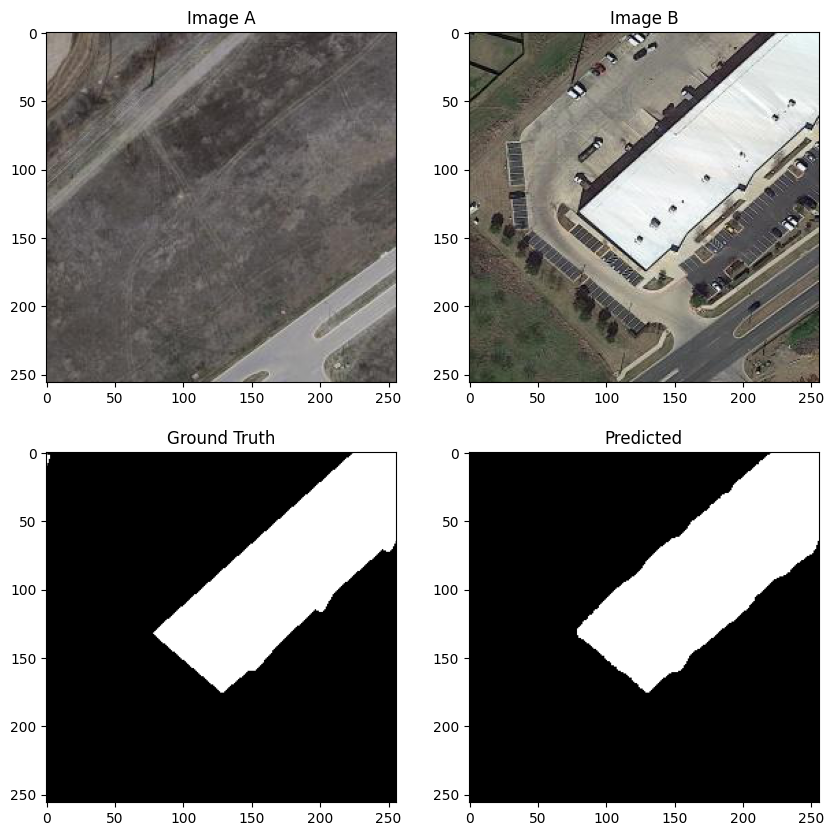

torch.Size([1, 256, 256])
name: test_121_0768_0256.png
./samples test_121_0768_0256.png test_121_0768_0256


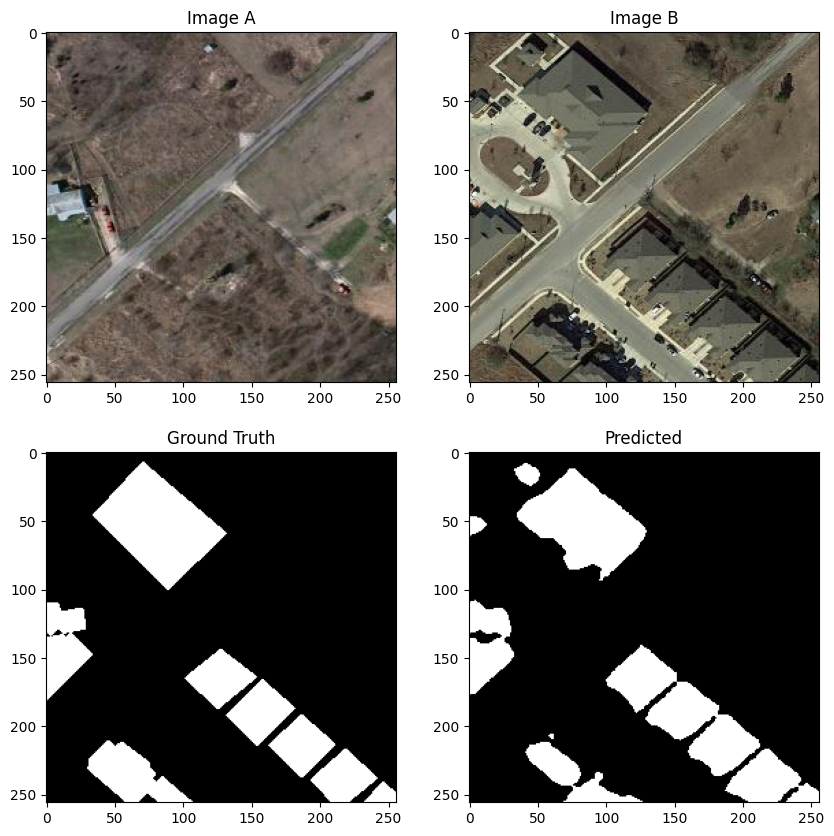

torch.Size([1, 256, 256])
name: test_2_0000_0000.png
./samples test_2_0000_0000.png test_2_0000_0000


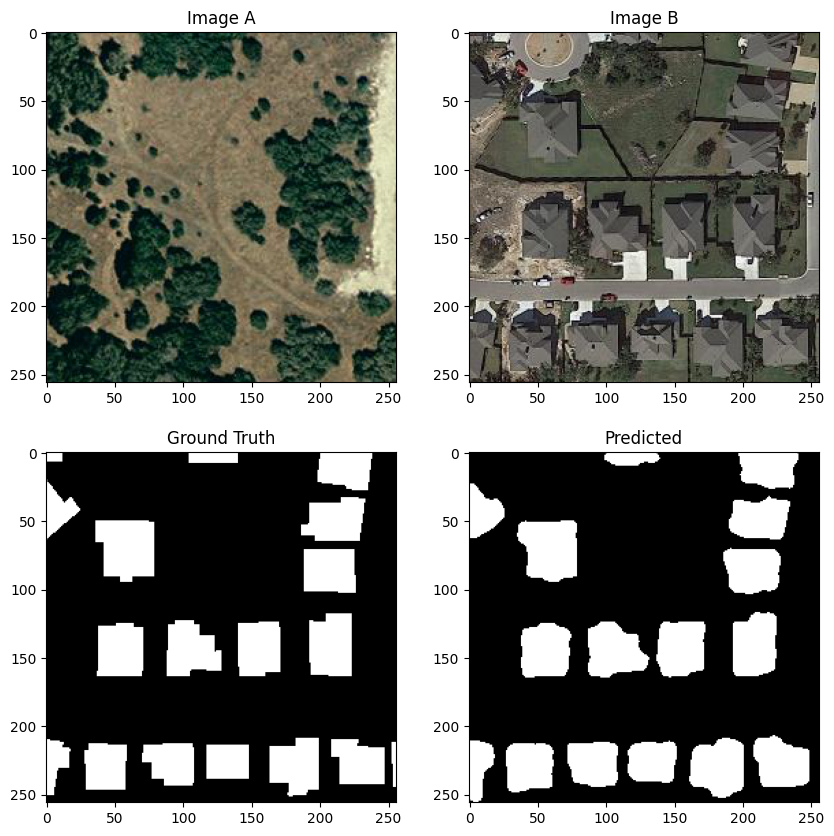

torch.Size([1, 256, 256])
name: test_2_0000_0512.png
./samples test_2_0000_0512.png test_2_0000_0512


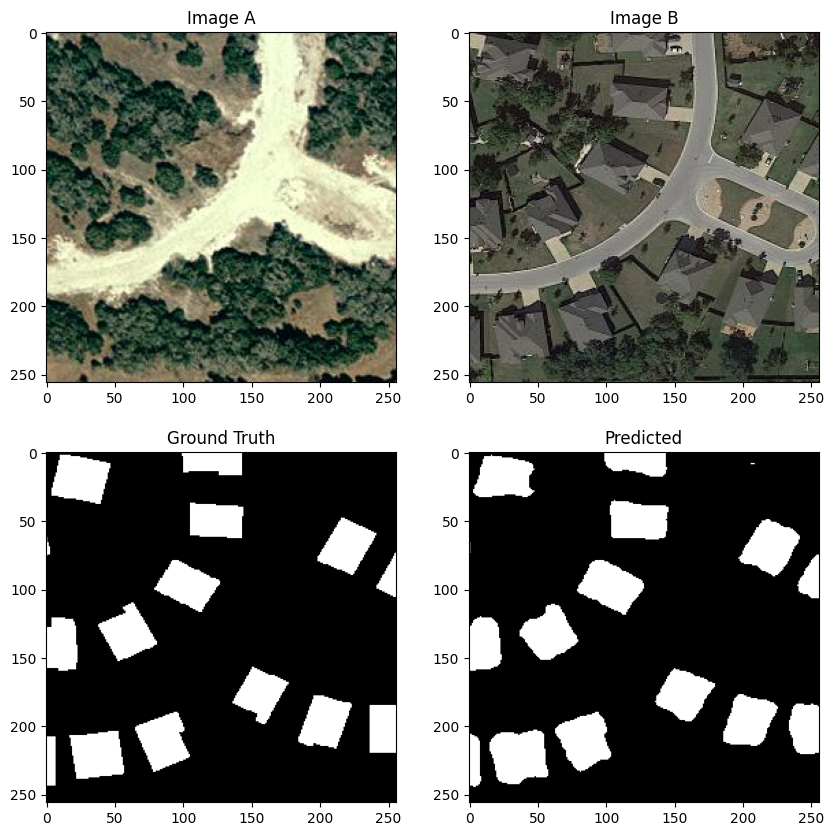

torch.Size([1, 256, 256])
name: test_55_0256_0000.png
./samples test_55_0256_0000.png test_55_0256_0000


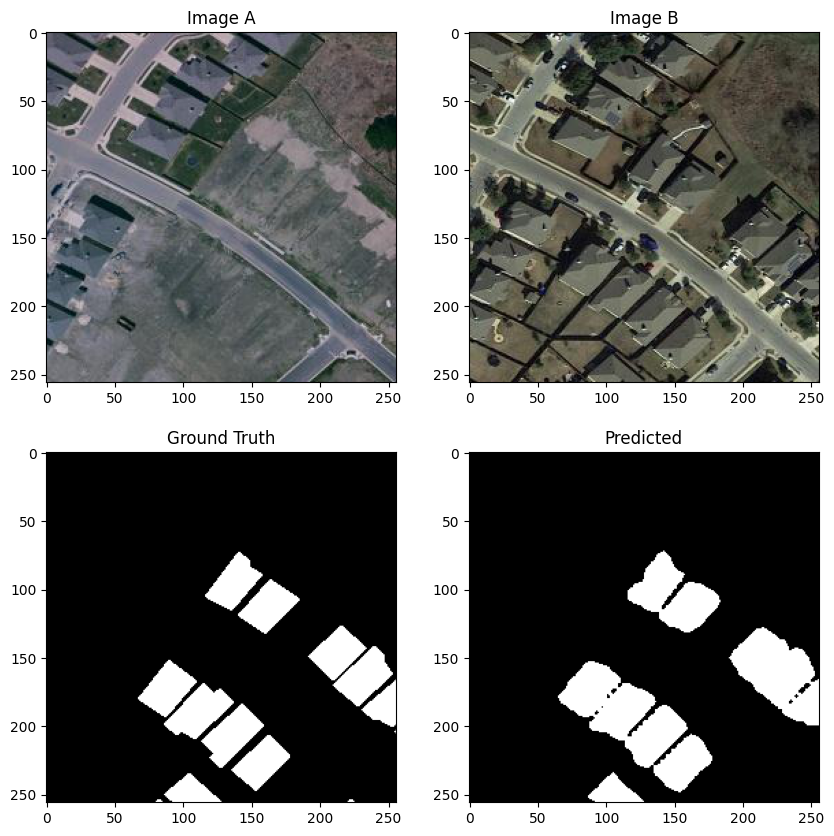

torch.Size([1, 256, 256])
name: test_77_0512_0256.png
./samples test_77_0512_0256.png test_77_0512_0256


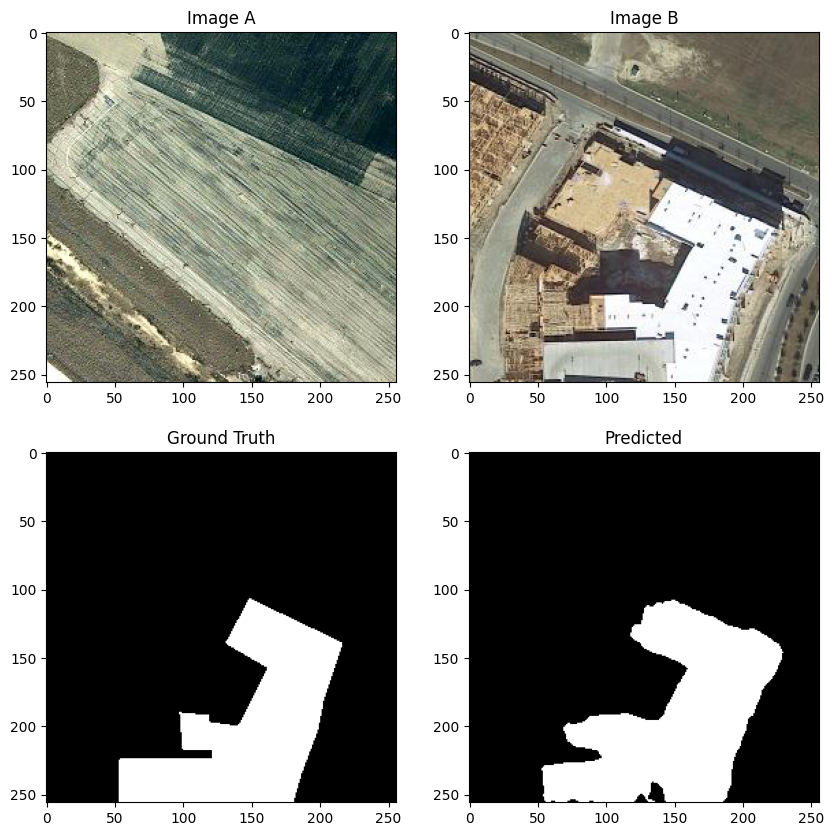

In [12]:

model = ChangeDetectionModel(opt)  # Create a change detection model instance
model.setup(opt)
save_path = opt.results_dir  # Get the save path from options
mkdir(save_path)  # Create the save directory
model.eval()  # Set the model to evaluation mode

for i, data in enumerate(dataloader):
    model.set_input(data)  # Set input data for the model
    pred = model.test(val=False)  # Perform inference and get predictions
    img_path = model.get_image_paths()  # Get image paths 
    save_images(pred, save_path, img_path)  # Save the predictions
    visualize_results('./samples', img_path[0]) 
